# Making PyROOT plots

## Summary:
If you are working with Histogrammar in Python and want to use ROOT to draw plots, read this notebook.

**Original Author:** [Jim Pivarski](http://histogrammar.org/docs/tutorials/python-pyroot/)

## Preliminaries
This tutorial uses the Python version of Histogrammar. See the installation guide for installing version 1.0.4 or later.

In [32]:
!pip install histogrammar --user

It also uses the CMS public dataset. Use the following to create an iterator over the data (and refresh it if you use up all the events). You will need a network connection.

In [1]:
from histogrammar.tutorial import cmsdata
events = cmsdata.EventIterator()

We also need basics: ROOT and histogrammar

In [2]:
import ROOT
#%jsroot on 
import histogrammar

Welcome to JupyROOT 6.07/07


pretty `%jsroot` disabled since I believe it doesn't support `root.TEfficiency` plots (`histogrammar.Fraction` plots that are shown below do not work)

## First histogram
Simple things first: you have some data in Python (events) and you want to see how they’re distributed. How do you do that in Histogrammar?

Like this:

In [3]:
histogram = histogrammar.Bin(100, 0, 100, lambda event: event.met.pt)

for i, event in enumerate(events):
    if i == 1000: break
    histogram.fill(event)

Now we can plot this histogram with pyROOT

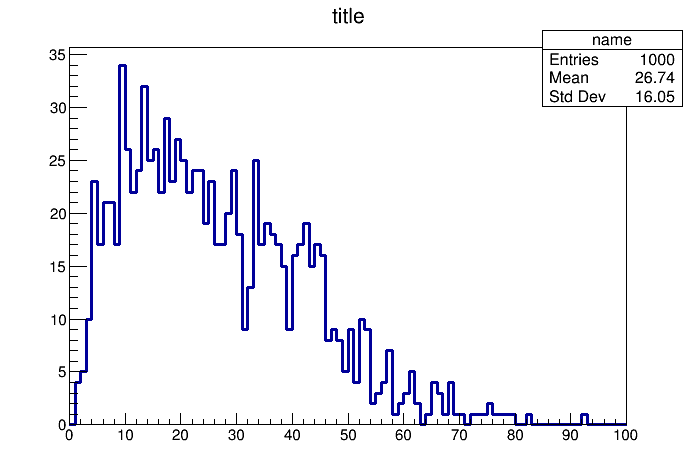

In [4]:
c1 = ROOT.TCanvas()
roothist = histogram.plot.root("name", "title")
roothist.Draw()
c1.Draw()

## What just happened?

The first line,

```python
from histogrammar import *
```

imports the basic functions and classes you need to define plots. The next gets to the heart of what Histogrammar is all about. It defines an empty histogram:
```python
histogram = Bin(100, 0, 100, lambda event: event.met.pt)
```
As a ROOT user, you are no doubt familiar with the concept of a histogram as an empty container that must be filled to be meaningful. However, the fill rule lambda event: event.met.pt may be unexpected.

In a ROOT typical script, you would declare (“book”) a suite of empty histograms in an initialization stage and then fill them in a loop over a zillion events. The physics-specific logic of what to put in each histogram can end up being far from the booking code.

In Histogrammar, the rule for how to fill the histogram is provided in the constructor, so that the loop can be automated with no input from the data analyst. Although this is useful in itself for maintainability (it’s easier to spot incongruities between the binning and the fill rule when they’re right next to each other), it is also important for frameworks like Apache PySpark that distribute the fill operation. Without consolidating the fill logic like this, a PySpark aggregate call would be very difficult to maintain.

Finally, the last line
```python
roothist = histogram.plot.root("name", "title")
```
creates a ROOT object from the Histogrammar object. In this case, it is a ROOT.TH1D, but the exact choice depends on what kind of Histogrammar object you’re converting.

You can style and manipulate this ROOT object as you ordinarily would, using ROOT functions. The intention of Histogrammar is not to replace ROOT or any other plotting framework, but to provide an alternate means of aggregation that cuts across frameworks and encourages sharing of data, using each tool for what it does best.
Composability

## Composability

In the above, it might seem that Bin is Histogrammar’s word for “histogram,” but it is more general than that. The Bin constructor has several arguments with default values:

* **value:** how to fill a bin between the low and high edges;
* **underflow:** what to do with data below the low edge;
* **overflow:** what to do with data above the high edge;
* **nanflow:** what to do with data that is not a number (NaN).

ROOT would fill the value of each bin, as well as the underflow and overflow, with a count of entries. (Histogrammar additionally has a “nanflow” so that every input value fills some bin.) This is the most common case, so Histogrammar has Count() as default values for these arguments.

Here, the similarity ends. Histogrammar’s Count is an aggregator of the same sort as Bin, and they can be used interchangeably. You could have counted the data instead of binning it:

In [5]:
count = histogrammar.Count()

for i, event in enumerate(events):
    if i == 1000: break
    count.fill(event)

print(count)

<Count 1000.0>


produces `<Count 1000.0>`, though this is only useful if you didn’t already know how many elements you were looping over.

Let’s try something more interesting: put a Bin of Count inside of a Bin.

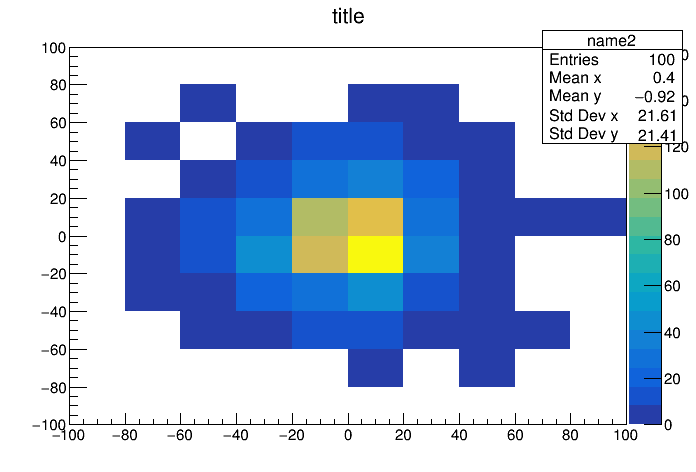

In [6]:
hist2d = histogrammar.Bin(10, -100, 100, lambda event: event.met.px,
             value = histogrammar.Bin(10, -100, 100, lambda event: event.met.py))

for i, event in enumerate(events):
    if i == 1000: break
    hist2d.fill(event)

roothist = hist2d.plot.root("name2", "title")
roothist.Draw("colz")
c1.Draw()

## 3D histograms

Histogrammar does not have a known conversion from Bin of Bin of Bin of Count to a corresponding ROOT object. The types of histograms you can build with Histogrammar is literally infinite, but there is a finite set of patterns mapping Histogrammar objects onto objects in a given plotting library. The Histogrammar-ROOT front-end may someday handle three-dimensional histograms, but as of version 0.7 it does not.

Nevertheless, the aggregated data is available inside hist3d. Explore it with Python’s dir() or tab-completion and come up with creative ways to visualize it.

In [7]:
hist3d = histogrammar.Bin(10, -100, 100, lambda muon: muon.px,
             histogrammar.Bin(10, -100, 100, lambda muon: muon.py,
                 histogrammar.Bin(10, -100, 100, lambda muon: muon.pz)))

for i, event in enumerate(events):
    if i == 1000: break
    for muon in event.muons:
        hist3d.fill(muon)

In [8]:
import imageio
images = []
    
for i, x in enumerate(hist3d.values):
    low, high = hist3d.range(i)
    roothist = x.plot.root("slice {}".format(i), "{} <= px < {}".format(low, high))
    roothist.Draw("colz")
    ROOT.gPad.SaveAs("./Outputs/slice_{}.png".format(i))
    images.append(imageio.imread("./Outputs/slice_{}.png".format(i)))
imageio.mimsave('./Outputs/hist3d.gif', images, fps=5)

Info in <TCanvas::Print>: png file ./Outputs/slice_0.png has been created
Info in <TCanvas::Print>: png file ./Outputs/slice_1.png has been created
Info in <TCanvas::Print>: png file ./Outputs/slice_2.png has been created
Info in <TCanvas::Print>: png file ./Outputs/slice_3.png has been created
Info in <TCanvas::Print>: png file ./Outputs/slice_4.png has been created
Info in <TCanvas::Print>: png file ./Outputs/slice_5.png has been created
Info in <TCanvas::Print>: png file ./Outputs/slice_6.png has been created
Info in <TCanvas::Print>: png file ./Outputs/slice_7.png has been created
Info in <TCanvas::Print>: png file ./Outputs/slice_8.png has been created
Info in <TCanvas::Print>: png file ./Outputs/slice_9.png has been created


![imageio gif](./Outputs/hist3d.gif "be there in a giffy")

This could be improved with better binning, better ROOT styling (such as a fixed colz scale), and animated GIF conversion (pause before repeating), but you get the idea.

## Visual tour of Histogrammar primitives

We managed to produce three different visualizations with only `Count` and `Bin`, but there are two dozen different kinds of primitives to work with. Let’s try a few more.

`Average` is a drop-in replacement for `Count` that averages a quantity instead of counting entries.

In [9]:
average = histogrammar.Average(lambda event: event.met.pt)

for i, event in enumerate(events):
    if i == 1000: break
    average.fill(event)

print(average)

<Average mean=25.0640973929>


If we bin it, we approximate a two-dimensional distribution as a function.

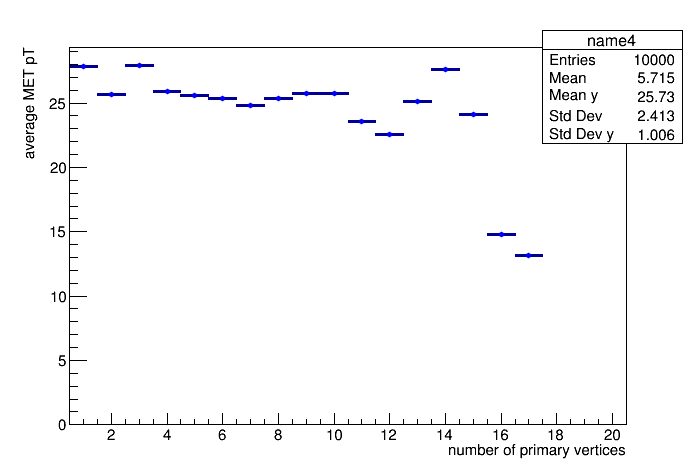

In [10]:
pt_vs_vertices = histogrammar.Bin(20, 0.5, 20.5, lambda event: event.numPrimaryVertices,
                     histogrammar.Average(lambda event: event.met.pt))

events = cmsdata.EventIterator()
for i, event in enumerate(events):
    if i == 10000: break
    pt_vs_vertices.fill(event)

roothist = pt_vs_vertices.plot.root("name4")
roothist.GetXaxis().SetTitle("number of primary vertices")
roothist.GetYaxis().SetTitle("average MET pT")
roothist.Draw()
c1.Draw()

This is a profile plot (`roothist` is literally a `ROOT.TProfile`), which should be familiar to ROOT users. Profile plots usually have error bars, but the required information to make the error bar (variance in each bin) is not available because we only accumulated the averages.

A primitive called `Deviate` accumulates mean and variance:

In [11]:
deviate = histogrammar.Deviate(lambda event: event.met.pt)

for i, event in enumerate(events):
    if i == 1000: break
    deviate.fill(event)

print(deviate)

<Deviate mean=24.5114851815 variance=279.49272031>


Why the weird name? Every primitive in Histogrammar is a verb, and “variance” and “standard deviation” are nouns. Type-safe versions of Histogrammar— which does not include Python— use verb tenses to specify which stage of development the primitive is in. Python just uses duck typing.)

All we have to do to get error bars is to swap `Average` for `Deviate`.

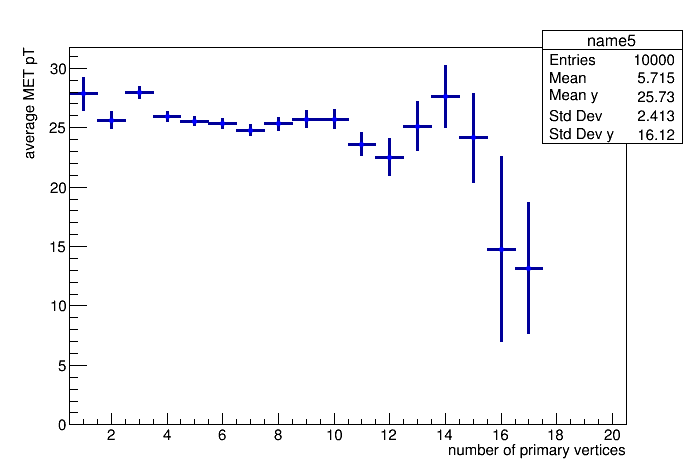

In [12]:
pt_vs_vertices = histogrammar.Bin(20, 0.5, 20.5, lambda event: event.numPrimaryVertices,
                     histogrammar.Deviate(lambda event: event.met.pt))

events = cmsdata.EventIterator()
for i, event in enumerate(events):
    if i == 10000: break
    pt_vs_vertices.fill(event)

roothist = pt_vs_vertices.plot.root("name5")
roothist.GetXaxis().SetTitle("number of primary vertices")
roothist.GetYaxis().SetTitle("average MET pT")
roothist.Draw()
c1.Draw()

It may be useful to know that every primitive has an `entries` (number of entries) field, and `Count` is nothing but a number of entries. Therefore, anything based on `Bin` can be turned into a simple histogram *without re-filling*.

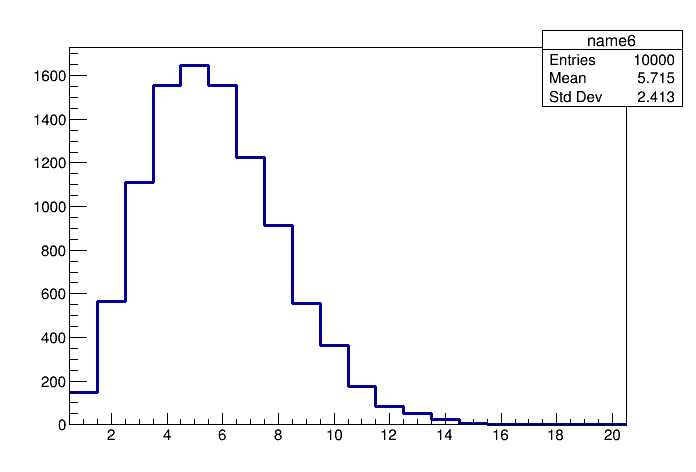

In [13]:
roothist2 = pt_vs_vertices.histogram().plot.root("name6")
roothist2.Draw()
c1.Draw()

This can help you answer questions about your plots using data that you already have on-hand.

##Alternate binning methods

`Count`, `Average`, and `Deviate` differ from `Bin` in one important aspect: they aggregate data, but do not pass it on to a sub-aggregator. If you compose aggregators into a tree, `Count`, `Average`, and `Deviate` will always be leaves and `Bin` will always be an internal node. This distinction is made in the [specification](http://histogrammar.org/docs/specification/1.0/) as primitives of “the first kind,” “the second kind,” etc. (The allusion to alien encounters is intentional.)

Peruse the specification to see what other “first kind” primitives you can make and think about how you’d be able to use things like quantiles and min/max per bin in an analysis. In this tutorial, we move on to alternate binning methods.

Standard binning slices a numeric interval into equal-length subintervals. The aggregator must do something with values that fall below (underflow) or above (overflow) the interval, and the data analyst has to guess an appropriate interval. It’s not uncommon to make a histogram of, say, momentum, only to discover that the tail reaches higher than you expected (cutting it off) or lower than you expected (compressing the meaningful information into one or two bins). You then have to re-fill the histogram, which is aggregating when it happens frequently or takes a long time to fill.

If we replace the “dense vector” of a standard histogram with a “sparse vector,” in which only non-zero values are filled, then there is no need to specify a minimum and maximum bin before filling. Consider the following:

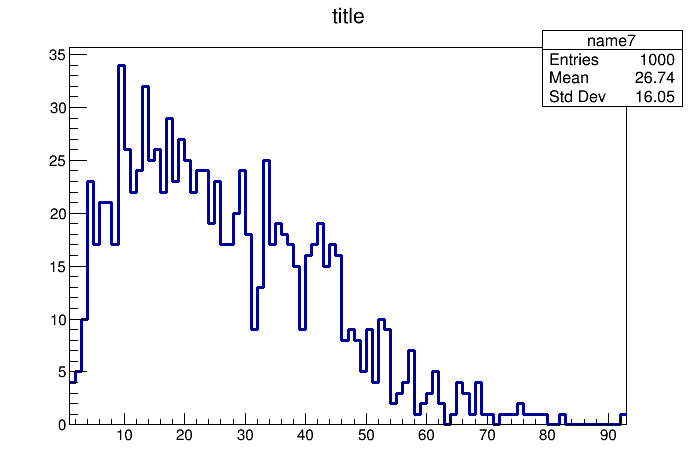

In [14]:
histogram = histogrammar.SparselyBin(1.0, lambda event: event.met.pt)

events = cmsdata.EventIterator()
for i, event in enumerate(events):
    if i == 1000: break
    histogram.fill(event)

roothist = histogram.plot.root("name7", "title")
roothist.Draw()
c1.Draw()

This histogram was created with no prior knowledge that the minimum event.met.pt would be 0 and the maximum would be 93. Only the bin width (the first argument, 1.0 momentum units per bin) had to be specified.

To see how this histogram differs, print the bins:

In [15]:
print(histogram.bins)

{1: <Count 4.0>, 2: <Count 5.0>, 3: <Count 10.0>, 4: <Count 23.0>, 5: <Count 17.0>, 6: <Count 21.0>, 7: <Count 21.0>, 8: <Count 17.0>, 9: <Count 34.0>, 10: <Count 26.0>, 11: <Count 22.0>, 12: <Count 24.0>, 13: <Count 32.0>, 14: <Count 25.0>, 15: <Count 26.0>, 16: <Count 22.0>, 17: <Count 29.0>, 18: <Count 23.0>, 19: <Count 27.0>, 20: <Count 25.0>, 21: <Count 22.0>, 22: <Count 24.0>, 23: <Count 24.0>, 24: <Count 19.0>, 25: <Count 23.0>, 26: <Count 17.0>, 27: <Count 17.0>, 28: <Count 20.0>, 29: <Count 24.0>, 30: <Count 18.0>, 31: <Count 9.0>, 32: <Count 13.0>, 33: <Count 25.0>, 34: <Count 17.0>, 35: <Count 19.0>, 36: <Count 18.0>, 37: <Count 17.0>, 38: <Count 15.0>, 39: <Count 9.0>, 40: <Count 16.0>, 41: <Count 17.0>, 42: <Count 19.0>, 43: <Count 15.0>, 44: <Count 17.0>, 45: <Count 16.0>, 46: <Count 8.0>, 47: <Count 9.0>, 48: <Count 8.0>, 49: <Count 5.0>, 50: <Count 9.0>, 51: <Count 4.0>, 52: <Count 10.0>, 53: <Count 9.0>, 54: <Count 2.0>, 55: <Count 3.0>, 56: <Count 4.0>, 57: <Count 7.0

It’s a Python dictionary, mapping non-empty bin indexes to Count objects. As new values are encountered, new bins are created, as well as a potentially new minimum and maximum.

In [16]:
print(len(histogram.bins), histogram.low, histogram.high, histogram.minBin, histogram.maxBin)

(79, 1.0, 93.0, 1, 92)


In [17]:
for i, event in enumerate(events):
    if i == 1000: break
    histogram.fill(event)

print(len(histogram.bins), histogram.low, histogram.high, histogram.minBin, histogram.maxBin)

(86, 0.0, 99.0, 0, 98)


Keep in mind that the memory use of a `Bin` is fixed, but a `SparselyBin` can grow without bound, depending on the distribution of the data. In particular, a distribution with a long tail might create a new bin for every tail event. Another concern is in converting a sparse histogram with far-flung values (such as `1e9` to represent “missing data”) into a dense histogram: all the intermediate bins would be created with zero value.

These are usually not issues in exploratory data analysis, where sparse histograms are the most useful. Just be sure to check `histogram.minBin` and `histogram.maxBin` before attempting to plot it and replace `SparselyBin` with `Bin` and well-chosen `low` and `high` values in the final analysis.

That said, `SparselyBin` can be composed with any sub-aggregators to make sparse profile plots:

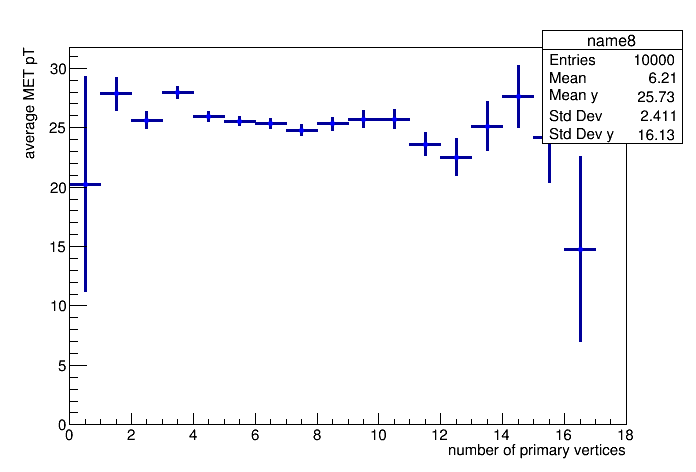

In [18]:
pt_vs_vertices = histogrammar.SparselyBin(1.0, lambda event: event.numPrimaryVertices,
                             histogrammar.Deviate(lambda event: event.met.pt))

events = cmsdata.EventIterator()
for i, event in enumerate(events):
    if i == 10000: break
    pt_vs_vertices.fill(event)

roothist = pt_vs_vertices.plot.root("name8")
roothist.GetXaxis().SetTitle("number of primary vertices")
roothist.GetYaxis().SetTitle("average MET pT")
roothist.Draw()
c1.Draw()

sparse two-dimensional histograms:

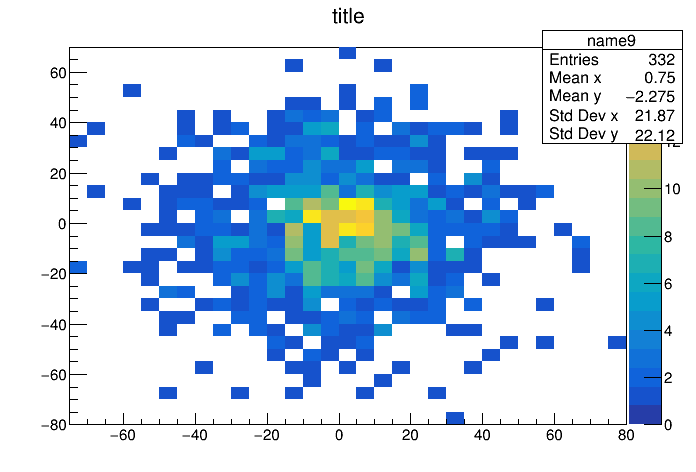

In [19]:
hist2d = histogrammar.SparselyBin(5.0, lambda event: event.met.px,
                     histogrammar.SparselyBin(5.0, lambda event: event.met.py))

events = cmsdata.EventIterator()
for i, event in enumerate(events):
    if i == 1000: break
    hist2d.fill(event)

roothist = hist2d.plot.root("name9", "title")
roothist.Draw("colz")
c1.Draw()

and so on.

Notice that this last example has negative indexes (print hist2d.bins.keys()) and a SparselyBin nested within a SparselyBin.

Histogrammar has a few other binning methods:

* **`CentrallyBin`**: a fixed set of irregularly spaced bins, defined by *bin centers*. Specifying the irregularly spaced bins by their centers has two nice features: no gaps and no underflow/overflow. It has an analogy with one-dimensional clustering. As of Histogrammar version 0.7, an automated translation to ROOT has not been defined.
* **`IrregularlyBin`**: could be used for irregularly spaced bins defined by *bin edges*, though it was intended for groups of plots with different cuts (such as a series of different pseudorapidity cuts or heavy ion centrality bins).
* **`Categorize`**: like `SparselyBin`, but with string-valued categories, rather than numbers. A histogram over a categorical domain is also known as a “bar chart.” There’s a certain program that excels at these.

All of these are aggregators “of the second kind” in the [specification](http://histogrammar.org/docs/specification/1.0/).

## Structures made of histograms

If “first kind” primitives like `Count`, `Average`, and `Deviate` are like stars and binning methods like `Bin`, `SparselyBin`, and `Categorize` are like stellar clusters, there are yet larger structures like galaxies and galactic clusters. Some of the things we do in an analysis involve a coordinated use of multiple histograms.

One of the most common is an efficiency plot: the probability of passing a cut as a function of some binned variable. You could make this by filling two histograms, one with the cut, the other without, and then dividing them, but Histogrammar has a built-in primitive:

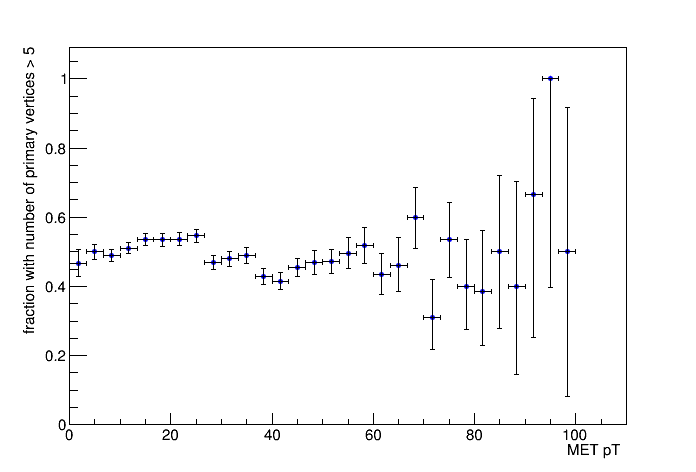

In [20]:
c1 = ROOT.TCanvas()
frac = histogrammar.Fraction(lambda event: event.numPrimaryVertices > 5,
                histogrammar.Bin(30, 0, 100, lambda event: event.met.pt))

events = cmsdata.EventIterator()
for i, event in enumerate(events):
    if i == 10000: break
    frac.fill(event)

roothist = frac.plot.root("name10", "title")
roothist.SetTitle(";MET pT ;fraction with number of primary vertices > 5")
roothist.Draw()
c1.Draw()

Note that the ROOT object returned by `frac.plot.root` is a `ROOT.TEfficiency`. This lets you choose different statistics for the error bars, which is not Histogrammar’s job, but ROOT’s.

There’s nothing stopping you from making an efficiency plot from a sparsely binned histogram. Histogrammar ensures that the numerator and denominator have the same binning.

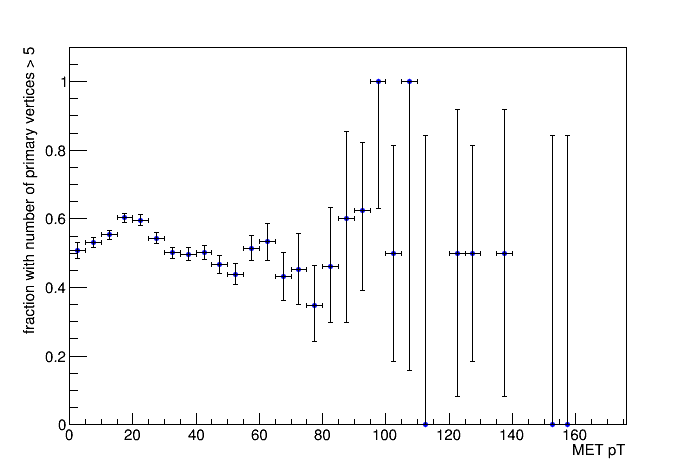

In [21]:
frac = histogrammar.Fraction(lambda event: event.numPrimaryVertices > 5,
                histogrammar.SparselyBin(5.0, lambda event: event.met.pt))

for i, event in enumerate(events):
    if i == 10000: break
    frac.fill(event)

roothist = frac.plot.root("name11", "title")
roothist.SetTitle(";MET pT;fraction with number of primary vertices > 5")
roothist.Draw()
c1.Draw()

In fact, you could compute the fraction of anything, even a simple count.

In [22]:
frac = histogrammar.Fraction(lambda event: event.numPrimaryVertices > 5, histogrammar.Count())

for i, event in enumerate(events):
    if i == 100: break
    frac.fill(event)

print(frac.numerator.entries / frac.denominator.entries)

0.37


Another of these superstructures is a suite of stacked or overlaid histograms. The `Stack` and `IrregularlyBin` primitives can both be thought of as extensions of `Fraction`. Whereas `Fraction` fills two sub-aggregators, one if a selection is satisfied and the other regardless, `Stack` fills *N + 1* sub-aggregators, each with the events that pass *N* successively tighter cuts.

In [23]:
stack = histogrammar.Stack([5, 10, 15, 20], lambda event: event.numPrimaryVertices,
              histogrammar.Bin(100, 0, 100, lambda event: event.met.pt))

for i, event in enumerate(events):
    if i == 1000: break
    stack.fill(event)

roothist = stack.plot.root("name12", "name13", "name14", "name15", "name16")
for i, h in enumerate(roothist.values()):
    h.SetFillColor(i + 2)

roothist.Draw()
c1.Draw()

AttributeError: 'StackedHistogramMethods' object has no attribute 'cuts'

The `stack.plot.root` call has to give names to each of the histograms (consider using Python’s `*args` syntax if you want to dynamically generates a list `args`) and it returns a Python `OrderedDict` of `ROOT.TH1D`. They keys of this dictionary are the cut thresholds and you can iterate over the values (as above) to give them styles.

The most common use of stacked histograms in high energy physics doesn’t fit the case above: usually, a stack shows data drawn from different sources. This illustrates a limitation in Histogrammar’s scope: all aggregators, no matter how complex with nested primitives, are filled with data from one data source. The lambda functions in almost all of the examples above took `event` as their argument. If you want to collect data from multiple sources, you’ll have to do multiple aggregation “runs.”

Suppose that we have two collections: muons and jets. (In a typical physics analysis, the datasets would all be events, drawn from different Monte Carlo generators.) For simplicity, we’ll make two lists from our `events` iterator:

In [24]:
muons = []
for i, event in enumerate(cmsdata.EventIterator()):
    if i == 1000: break
    for muon in event.muons:
        muons.append(muon)

jets = []
for i, event in enumerate(cmsdata.EventIterator()):
    if i == 1000: break
    for jet in event.jets:
        jets.append(jet)

And now we’ll make two sets of the same kind of histogram. Note that all Histogrammar aggregators have a copy() method to recursively copy the tree structure, making an identical but independent object, and a zero() method to do the same, but making an empty container, rather than an identical one.

In [25]:
template = histogrammar.Bin(100, -100, 100, lambda particle: particle.px)
muonsPlot = template.copy()
jetsPlot = template.copy()

for muon in muons:
    muonsPlot.fill(muon)

for jet in jets:
    jetsPlot.fill(jet)

The `Stack` primitive has a special constructor for taking histograms from different sources: if they’re not compatible (different bins), it will raise an exception.

In [27]:
stack = histogrammar.Stack.build(muonsPlot, jetsPlot)

roothist = stack.plot.root("name17", "name18")
for i, h in enumerate(roothist.values()):
    h.SetFillColor(i + 2)

roothist.Draw()
c1.Draw()

AttributeError: 'StackedHistogramMethods' object has no attribute 'cuts'

The beauty of this is that you don’t have to aggregate them again to stack them in a different order. Just change the order of `Stack.build`.

In [28]:
stack = histogrammar.Stack.build(jetsPlot, muonsPlot)

roothist = stack.plot.root("name19", "name20")
for i, h in enumerate(reversed(roothist.values())):
    h.SetFillColor(i + 2)

roothist.Draw()
c1.Draw()

AttributeError: 'StackedHistogramMethods' object has no attribute 'cuts'

The first order was better.)

Getting back to the relationship between `Fraction`, `Stack`, and `IrregularlyBin`, a `Fraction` is just a `Stack` with one cut. That is,

In [29]:
frac = histogrammar.Fraction(lambda event: event.numPrimaryVertices > 5,
                histogrammar.Bin(30, 0, 100, lambda event: event.met.pt))

is the same thing as

In [31]:
frac = histogrammar.Stack([5], lambda event: event.numPrimaryVertices,
             histogrammar.Bin(30, 0, 100, lambda event: event.met.pt))

# denominator is frac.values[0]
# numerator is frac.values[1]

So what’s `IrregularlyBin`? An event that satisfies a `Stack` threshold fills all sub-aggregators up to and including that one. Each sub-aggregator in the list covers a subinterval of the previous one. As a Venn diagram, the domains the sub-aggregators in a `Stack` cover would look like this:

![venn](./Outputs/stack_venn.png "cuts in a venn")

An event that satisfies a IrregularlyBin threshold fills exactly one sub-aggregator: their domains partition the space with a Venn diagram that looks like this:

![part](./Outputs/partition_venn.png "parts in a venn")

After filling, you simply overlay the plots. The `Stack` is guaranteed to not overlap because the first (back) histogram contains all events, the next contains a subset, etc. The plots of a `IrregularlyBin` may overlap, but each represents a distinct set of events.

Here is a real-world use of `Stack` and `IrregularlyBin`. You might want to compare the momenta of muons measured by different parts of the detector (these cuts on pseudorapidity (`eta`) correspond to qualitatively different parts of the CMS detector, which is where these data originated).

In [33]:
stack = histogrammar.Stack([0.8, 1.2, 1.7], lambda muon: abs(muon.eta),
              histogrammar.Bin(50, 0, 200, lambda muon: muon.p))

partition = histogrammar.IrregularlyBin([0.8, 1.2, 1.7], lambda muon: abs(muon.eta),
                           histogrammar.Bin(50, 0, 200, lambda muon: muon.p))

events = cmsdata.EventIterator()
for i, event in enumerate(events):
    if i == 10000: break
    for muon in event.muons:
        stack.fill(muon)
        partition.fill(muon)

rootstack = stack.plot.root("barrel", "overlap", "endcap-2", "endcap-1")
for i, h in enumerate(rootstack.values()):
    h.SetFillColor(i + 2)

rootstack.Draw()
c1.Draw()

AttributeError: 'StackedHistogramMethods' object has no attribute 'cuts'

In [34]:
rootpartition = partition.plot.root("barrel", "overlap", "endcap-2", "endcap-1")
for i, h in enumerate(rootpartition.values()):
    h.SetLineColor(i + 2)
    h.SetLineWidth(2)

rootpartition.Draw()
c1.Draw()

AttributeError: 'PartitionedHistogramMethods' object has no attribute 'cuts'

A `IrregularlyBin` could also be used to define a single, irregularly binned histogram by bin edges (as opposed to `CentrallyBin`, which uses bin centers). Just replace the sub-aggregator with `Count()`.

In [36]:
histogram = histogrammar.IrregularlyBin([-2.4, -1.7, -1.2, -0.8, 0.0, 0.8, 1.2, 1.7, 2.4],
                           lambda muon: muon.eta, histogrammar.Count())

for i, event in enumerate(events):
    if i == 1000: break
    for muon in event.muons:
        histogram.fill(muon)

print(histogram.cuts)

AttributeError: 'IrregularlyBin' object has no attribute 'cuts'

The first bin, for which `muon.eta` is at least minus infinity, has 1 muon. The next, which starts at –2.4 (the approximate edge of the detector), has 70 muons, continuing up to the last bin, which starts at 2.4 (the other edge of the detector), which also has 1 spurious muon. The first and last bins may be thought of as underflow and overflow because they extend to negative and positive infinity, or they may be treated as ordinary bins. The same is true of the first and last bins in a `CentrallyBin`.

Although this use of `IrregularlyBin` is not how it was originally intended, it is perfectly valid and should someday have an automated conversion to irregularly binned ROOT histograms. You should think of these primitives as your building blocks, provided to construct whatever statistic you need, and handle converting it to a visualization later.